# Import Libraries and Load Dataset

In [1]:
%%capture
#!git clone https://github.com/huggingface/transformers.git
!pip install datasets evaluate transformers[sentencepiece]
!pip install rouge_score
!pip install underthesea
!pip install pyvi
!pip install gdown

In [2]:
#%%capture

import gdown

!gdown 1jWDnP1xF01_pmeJYsRHxSVBkLZ0I9LAt #utils T5 for VQA

Downloading...
From (original): https://drive.google.com/uc?id=1jWDnP1xF01_pmeJYsRHxSVBkLZ0I9LAt
From (redirected): https://drive.google.com/uc?id=1jWDnP1xF01_pmeJYsRHxSVBkLZ0I9LAt&confirm=t&uuid=812ae51d-c3dc-490d-8df5-b23117e87785
To: /kaggle/working/utils.py
100%|████████████████████████████████████████| 109k/109k [00:00<00:00, 93.6MB/s]


In [3]:
from PIL import Image

import requests

import os
import shutil
import torch

from urllib.request import urlopen
from PIL import Image
import timm
import tqdm
import torch
from IPython.display import FileLink

In [4]:
import json

train_json = json.load(open('/kaggle/input/dsc24-vimmsd/vimmsd-train.json'))
dev_json = json.load(open('/kaggle/input/dsc24-vimmsd/vimmsd-public-test.json'))

# Image feature extraction

In [5]:
# images = []

# for key, item in train_json.items():
#     images.append(item['image'])

# for key, item in dev_json.items():
#     images.append(item['image'])

In [6]:
# source_all = ['/kaggle/input/dsc24-vimmsd/dev-images/dev-images',
#               '/kaggle/input/dsc24-vimmsd/train-images/train-images']

# destination = './images'
# #os.mkdir(destination)

# for source in source_all:
#     allfiles = os.listdir(source)
#     for f in allfiles:
#         src_path = os.path.join(source, f)
#         dst_path = os.path.join(destination, f)
#         shutil.copy(src_path, dst_path)

## BEiT

In [7]:
# model = timm.create_model(
#     'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
#     pretrained=True,
#     num_classes=0,  # remove classifier nn.Linear
# ).to('cuda')

# model = model.eval()
# data_config = timm.data.resolve_model_data_config(model)
# transforms = timm.data.create_transform(**data_config, is_training=False)

# img_w = {}

# def batch(iterable, n=1):
#     l = len(iterable)
#     for ndx in range(0, l, n):
#         yield iterable[ndx:min(ndx + n, l)]

In [8]:
# p = '/kaggle/working/images/'

# img_w = {}

# # get features for images, we will do this 3 images at a time to reduce time

# for x in tqdm.notebook.tqdm(batch(images, 3),total=int(len(images)/3)):
#     img = [Image.open(p + v).convert('RGB') for v in x]
#     print(x)

#     with torch.no_grad():
#         img  = torch.stack([transforms(i) for i in img]).to('cuda')
#         output = model.forward_features(img)[:,1:,:]

#     tmp_img_w = {k:v for k,v in zip(x,output)}

#     img_w.update(tmp_img_w)

#     del output
#     del tmp_img_w
#     del img
#     torch.cuda.empty_cache()

# torch.save(img_w, '/kaggle/working/beitv2-b-p.pt') # export for later used
# FileLink('/kaggle/working/beitv2-b-p.pt')

## Load extracted image features

In [9]:
import torch
from torch.nn.functional import normalize

img_w = torch.load('/kaggle/input/lovecat-beitv2-b-p/beitv2-b-p.pt') # already-saved features
len(img_w)

12218

In [10]:
img_w['ac7931bb887ad853b41675f07595bf04469970d1b099ffc8806a4ceaac7d7940.jpg'].shape

torch.Size([196, 768])

# Model

In [11]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

from utils import T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("VietAI/vit5-base")

model = T5ForConditionalGeneration.from_pretrained("VietAI/vit5-base").to('cuda')

model.add_imgw(img_w)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at VietAI/vit5-base and are newly initialized: ['resize_img_dim.bias', 'resize_img_dim.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Prepare datasets

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_json).T
test_df = pd.DataFrame(dev_json).T # public test

In [13]:
train_df['image_id'] = train_df['image'].astype(str)
test_df['image_id'] = test_df['image'].astype(str)

train_df['caption'] = train_df['caption'].astype(str)
test_df['caption'] = test_df['caption'].astype(str)

train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)



train_df['caption'] = train_df['caption'].str.lower()
test_df['caption'] = test_df['caption'].str.lower()

train_df.drop(columns=['image'], inplace=True)
test_df.drop(columns=['image'], inplace=True)

train_df.head()

,caption,label,image_id
0,cô ấy trên mạng vs cô ấy ngoài đời =))),multi-sarcasm,8ae451edcd8ebf697f8763ece249115813149c55733bf8...
1,người tâm linh giao tiếp với người thực tế :))),not-sarcasm,35370ffd6c791d6f8c4ab3dd4363ed468fab41e4824ee9...
2,hình như trăng hôm nay đẹp quá mọi người ạ! 😃 ...,multi-sarcasm,316fdd1477725b9fb1a55015ac06b68b92b50bd4303e08...
3,mọi người nghĩ sao về phát biểu của shark việt...,not-sarcasm,8a0f34e0e30e4e5cfb306933c1d25fa801a5da78646b59...
4,2 tay hai nàng chứ việc gì phải lệ hai hàng,multi-sarcasm,e517a5e95d1065886a7c815e82fe254381d4f9f4b244d4...


In [14]:
import pandas as pd

from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['label'])  # Features
y = train_df['label']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_test, y_test], axis=1)

In [15]:
print(train_df.shape, val_df.shape, test_df.shape)

(9724, 3) (1081, 3) (1413, 3)


In [16]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, TrainingArguments, Seq2SeqTrainingArguments
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["inputs"], max_length=400, truncation=True, padding=True
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["labels"], max_length=32, truncation=True, padding=True
        )
    model_inputs['labels'] = labels['input_ids']
    model_inputs['input_ids'] = model_inputs['input_ids']
    model_inputs["image_id"] = examples["image_id"]
    
    return model_inputs

In [17]:
dict_obj = {}

dict_obj['inputs'] = train_df['caption']
dict_obj['labels'] =  train_df['label']
dict_obj['image_id'] = train_df['image_id']
train_dataset = Dataset.from_dict(dict_obj)
tokenized_train_datasets = train_dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)

dict_obj = {}
dict_obj['inputs'] = val_df['caption']
dict_obj['labels'] =  val_df['label']
dict_obj['image_id'] = val_df['image_id']
val_dataset = Dataset.from_dict(dict_obj)
tokenized_val_datasets = val_dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)


#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

#2:   0%|          | 0/2 [00:00<?, ?ba/s]

#3:   0%|          | 0/2 [00:00<?, ?ba/s]

#4:   0%|          | 0/2 [00:00<?, ?ba/s]

#5:   0%|          | 0/2 [00:00<?, ?ba/s]

#6:   0%|          | 0/2 [00:00<?, ?ba/s]

#7:   0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#4:   0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


#3:   0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


#5:   0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


#6:   0%|          | 0/1 [00:00<?, ?ba/s]

#7:   0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [18]:
import random

import numpy as np

import torch

def set_SEED():
    SEED = 100
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [19]:
import os
from transformers.optimization import Adafactor, AdafactorSchedule
from transformers import DataCollatorForSeq2Seq
from utils import DataCollatorForSeq2Seq

os.environ["WANDB_DISABLED"] = "True"
set_SEED()

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

#Adam
training_args = Seq2SeqTrainingArguments(output_dir="./checkpoint",
                                      do_train=True,
                                      do_eval=True,
                                      num_train_epochs=1,
                                      learning_rate=2.5e-5,
                                      warmup_ratio=0.05,
                                      weight_decay=0.01,
                                      per_device_train_batch_size=8,
                                      per_device_eval_batch_size=8,
                                      logging_dir='./log',
                                      group_by_length=True,
                                      save_strategy="steps",
                                      evaluation_strategy="steps",
                                      save_total_limit=5,
                                      eval_steps=100,
                                      logging_steps = 100,
                                      save_steps=100,
                                      load_best_model_at_end= True,
                                      fp16=True,
                                      seed=42,
                                      )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [20]:
tokenized_train_datasets

Dataset({
    features: ['labels', 'image_id', 'input_ids', 'attention_mask'],
    num_rows: 9724
})

In [21]:
tokenized_val_datasets

Dataset({
    features: ['labels', 'image_id', 'input_ids', 'attention_mask'],
    num_rows: 1081
})

In [22]:
trainer = Seq2SeqTrainer(
    model = model,
    args = training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_val_datasets,
    data_collator=data_collator,
)

trainer.train()

Step,Training Loss,Validation Loss
100,5.465300,0.126961
200,0.130900,0.120529
300,0.128000,0.110442
400,0.128500,0.126763
500,0.118600,0.115989
600,0.113300,0.109417
700,0.110100,0.107263
800,0.122100,0.110142
900,0.112800,0.105282
1000,0.112100,0.107546


TrainOutput(global_step=1216, training_loss=0.5561858141108563, metrics={'train_runtime': 937.944, 'train_samples_per_second': 10.367, 'train_steps_per_second': 1.296, 'total_flos': 4630477128929280.0, 'train_loss': 0.5561858141108563, 'epoch': 1.0})

In [23]:
import matplotlib.pyplot as plt
import json

# save loss
log_history = {'log_history':trainer.state.log_history}

with open('logs.json', 'w', encoding='utf-8') as f:
    json.dump(log_history, f, ensure_ascii=False, indent=4)

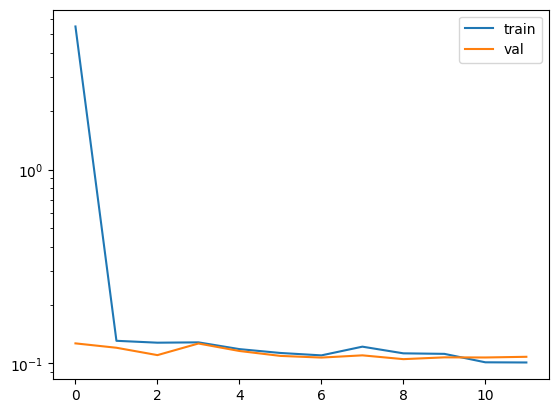

In [24]:
from matplotlib import pyplot

train_loss = {i['step']:i['loss'] for i in log_history['log_history'] if 'loss' in i.keys()}
eval_loss = {i['step']:i['eval_loss'] for i in log_history['log_history'] if 'eval_loss' in i.keys()}
plt.plot(list(train_loss.values()))
plt.plot(list(eval_loss.values()))

plt.yscale('log')
plt.legend(['train','val'])

# Load checkpoints and predict

In [25]:
torch.cuda.empty_cache()
# model = T5ForConditionalGeneration.from_pretrained("/kaggle/working/checkpoint/checkpoint-500")
# model.to('cuda')
# model.add_imgw(img_w)

In [26]:

dict_obj = {}
dict_obj['inputs'] = test_df['caption']
dict_obj['labels'] =  test_df['label']
dict_obj['image_id'] = test_df['image_id']
test_dataset = Dataset.from_dict(dict_obj)
tokenized_test_datasets = test_dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


#4:   0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


#5:   0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


#7:   0%|          | 0/1 [00:00<?, ?ba/s]

#6:   0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [27]:
import gc
torch.cuda.empty_cache()
gc.collect()

2844

In [28]:
tokenized_test_datasets

Dataset({
    features: ['labels', 'image_id', 'input_ids', 'attention_mask'],
    num_rows: 1413
})

In [29]:
#test executing time: 2888s ~ 48m
import torch 
import numpy as np
from datasets import load_metric
metrics = load_metric('accuracy')

torch.cuda.empty_cache()
max_target_length = 10
dataloader = torch.utils.data.DataLoader(tokenized_test_datasets, collate_fn=data_collator, batch_size=4) #replace tokenized_dev_datasets with tokenized_test_datasets

predictions = []
references = []

for i, batch in enumerate(tqdm(dataloader)):
    # greedy search
    outputs = model.generate(image_id = batch['image_id'],
        input_ids=batch['input_ids'].to('cuda'),
        max_length=max_target_length,
        attention_mask=batch['attention_mask'].to('cuda'),
        return_dict_in_generate=True, output_attentions=True,)

    #beam search for now   
    # outputs = model.generate(
    #     image_id = np.repeat(batch['image_id'], 7),
    #     input_ids=batch['input_ids'].to('cuda'),
    #     max_length=max_target_length,
    #     attention_mask=batch['attention_mask'].to('cuda'),
    #     return_dict_in_generate=True, output_attentions=True,
    #     num_beams=7,
    #     no_repeat_ngram_size=2)
    
    with tokenizer.as_target_tokenizer():
        outputs = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in outputs.sequences]
        labels = np.where(batch['labels'] != -100,  batch['labels'], tokenizer.pad_token_id)
        # actuals = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in labels]

    predictions.extend(outputs)


  0%|          | 0/354 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [30]:
len(predictions)

1413

In [31]:
def postprocessing(t):
    t = t.lower()
    t = t.replace('\\','')
    return t

test_predicted = {k:postprocessing(i) for k,i in zip(dev_json.keys(),predictions)}

In [32]:
test_predicted

{'0': 'multi-sarcasm',
 '1': 'multi-sarcasm',
 '2': 'not-sarcasm',
 '3': 'multi-sarcasm',
 '4': 'not-sarcasm',
 '5': 'not-sarcasm',
 '6': 'not-sarcasm',
 '7': 'not-sarcasm',
 '8': 'not-sarcasm',
 '9': 'not-sarcasm',
 '10': 'multi-sarcasm',
 '11': 'multi-sarcasm',
 '12': 'multi-sarcasm',
 '13': 'not-sarcasm',
 '14': 'multi-sarcasm',
 '15': 'not-sarcasm',
 '16': 'not-sarcasm',
 '17': 'not-sarcasm',
 '18': 'not-sarcasm',
 '19': 'not-sarcasm',
 '20': 'not-sarcasm',
 '21': 'not-sarcasm',
 '22': 'not-sarcasm',
 '23': 'not-sarcasm',
 '24': 'multi-sarcasm',
 '25': 'multi-sarcasm',
 '26': 'not-sarcasm',
 '27': 'not-sarcasm',
 '28': 'not-sarcasm',
 '29': 'not-sarcasm',
 '30': 'multi-sarcasm',
 '31': 'not-sarcasm',
 '32': 'not-sarcasm',
 '33': 'not-sarcasm',
 '34': 'not-sarcasm',
 '35': 'multi-sarcasm',
 '36': 'not-sarcasm',
 '37': 'multi-sarcasm',
 '38': 'not-sarcasm',
 '39': 'not-sarcasm',
 '40': 'multi-sarcasm',
 '41': 'not-sarcasm',
 '42': 'not-sarcasm',
 '43': 'not-sarcasm',
 '44': 'not-sarc

In [33]:
with open('results.json', 'w') as fp:
    json.dump(test_predicted, fp,ensure_ascii=True,indent=True)